In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import features
from autoRIFT import autoRIFT
from collections import namedtuple
from pathlib import Path
import itertools

import warnings
warnings.filterwarnings("ignore")
# from autoRIFT import autoriftcore
# from geogrid import GeogridOptical

In [2]:
pwd

'/home/micromamba/scripts'

In [3]:
# autorift_cmd = str(Path('testautoRIFT.py').resolve())
# geogrid_cmd = str(Path('testGeogridOptical.py').resolve())

In [4]:
cd /home/micromamba/data/spot/landslide_2_rangitikei

/home/micromamba/data/spot/landslide_2_rangitikei


## Functions

In [5]:
def read_raster(path,bands=1,crs=False):
    # From rasterio docs with modifications
    with rio.open(path) as dst:
        array = dst.read(bands)
        profile = dst.profile
        crs_val = dst.crs
        # array = np.moveaxis(array,0,-1)
    
    result = [array, profile]

    if crs:
        result.append(crs_val)

    return result


def write_raster(array,profile,out_path,nodata,dtype):
    # From rasterio docs:
    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rio.Env():
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=dtype,
            count=1,
            nodata=nodata,
            compress='lzw')

        with rio.open(out_path, 'w', **profile) as dst:
            dst.write(array.astype(dtype), 1)

    return out_path

def polygon_to_raster(gdf,template_path,value=1,crs=False):
    if isinstance(gdf,str):
        pol = gpd.read_file(gdf)
    else:
        pol = gdf

    with rio.open(template_path) as dst:
        profile = dst.profile
        template_crs = dst.crs
        template_transform = profile['transform']
        template_shape = dst.shape

    # if crs != pol.crs:
    #   raise Exception('CRSs do not match!')

    geojsons = [x['geometry'] for x in pol.geometry.__geo_interface__['features']]
    if isinstance(value,str):
        shapes = [tuple(x) for x in zip(geojsons,pol[value])]
    else:
        shapes = [(x,value) for x in geojsons]

    array = features.rasterize(shapes, out_shape=template_shape, transform=template_transform)
    
    result = [array, profile]
    if crs:
        result.append(template_crs)

    return result

def write_autorift(path,dataset,obj,profile):
    
    # meta = dict(driver='GTiff', dtype=None, nodata=0.0, width=None, height=None, count=1,
    #         crs=None, transform=None, blocksize=256, tiled=True, compress='lzw', interleave='pixel')
    gtfm = profile['transform']
    xstep_pre, _, xstart, _, ystep_pre, ystart, _, _, _ = list(gtfm)

    xstep = xstep_pre * obj.SkipSampleX
    ystep = ystep_pre * obj.SkipSampleY

    profile['dtype'] = obj.Dx.dtype
    profile['width'] = obj.Dx.shape[1]
    profile['height'] = obj.Dx.shape[0]
    profile['transform'] = rio.transform.Affine(xstep, 0.0, xstart+xstep, 0.0, ystep, ystart+ystep)
    
    if dataset == 'Dx':
        write_raster(obj.Dx*xstep_pre,profile,path,nodata=0.0,dtype=rio.float32)
        # rio_write(path,obj.Dx*xstep_pre,meta)
    elif dataset == 'Dy':
        write_raster(obj.Dy*xstep_pre,profile,path,nodata=0.0,dtype=rio.float32)
        # rio_write(path,obj.Dy*xstep_pre,meta)
    else:
        print('No valid dataset specified! Nothing will be written')

def run_autorift(reference,secondary,step=8,min_window=32,max_window=128,min_distance=0,max_distance=5):
    # intizialize
    obj = autoRIFT()

    # set imagery
    obj.I1 = reference.astype(np.float32)
    obj.I2 = secondary.astype(np.float32)

    # Sampling
    obj.SkipSampleX = step
    obj.SkipSampleY = step

    # Chip size
    obj.ChipSizeMinX = min_window
    obj.ChipSizeMaxX = max_window
    obj.ChipSize0X = float(16)
    obj.ScaleChipSizeY = int(1)

    # Search Area
    obj.minSearch = min_distance
    obj.SearchLimitX = max_distance
    obj.SearchLimitY = max_distance

    # Result grid
    # m,n = obj.I1.shape
    # xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    # yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    # nd = xGrid.__len__()
    # md = yGrid.__len__()
    # obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    # obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))

    # m, n = reference.shape
    # xVals = np.arange(obj.SkipSampleX,n-obj.SkipSampleX,obj.SkipSampleX)
    # yVals = np.arange(obj.SkipSampleY,m-obj.SkipSampleY,obj.SkipSampleY)
    # ncol = int(xVals.shape[0])
    # nrow = int(yVals.shape[0])
    # xGrid = np.repeat(np.reshape(xVals,(1,ncol)),nrow,axis=0)
    # yGrid = np.repeat(np.reshape(yVals,(nrow,1)),ncol,axis=1)
    # obj.xGrid = xGrid
    # obj.yGrid = yGrid
    
    m,n = obj.I1.shape
    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
    # noDataMask = np.logical_not(obj.xGrid)
    
    # Run autoRIFT
    obj.uniform_data_type()
    # obj.preprocess_filt_hps()
    obj.runAutorift()
    
    return obj

## AutoRIFT Inputs
**I1**  reference image (extracted image patches defined as "source")

**I2**  secondary image (extracted image patches defined as "template"; displacement = motion vector of I2 relative to I1 which should be acquired earlier in our convention)

**xGrid** [units = integer image pixels]  horizontal reference image pixel index at each grid point

**yGrid**  [units = integer image pixels]  vertical reference image pixel index at each grid point
(if xGrid and yGrid not provided, a regular grid spanning the entire image will be automatically set up, which is similar to the conventional ISCE module, "ampcor" or "denseampcor")

**Dx0**  [units = integer image pixels]  horizontal "downstream" search location (that specifies the horizontal pixel displacement of the template's search center relative to the source's) at each grid point

**Dy0**  [units = integer image pixels]  vertical "downstream" reach location (that specifies the vertical pixel displacement of the template's search center relative to the source's) at each grid point
(if Dx0 and Dy0 not provided, an array with zero values will be automatically assigned and there will be no offsets of the search centers)

**ChipSizeMinX** [units = integer image pixels]  Minimum size (in horizontal direction) of the template (chip) to correlate (default = 32; could be scalar or array with same dimension as xGrid)

**ChipSizeMaxX** [units = integer image pixels]  Maximum size (in horizontal direction) of the template (chip) to correlate (default = 64; could be scalar or array with same dimension as xGrid)

**ChipSize0X** [units = integer image pixels]  Minimum acceptable size (in horizontal direction) of the template (chip) to correlate (default = 32)

**GridSpacingX** [units = integer image pixels]  Grid Spacing (in horizontal direction) (default = 32; note GridSpacingX can be smaller than ChipSize0X leading to dependent chips)

**ScaleChipSizeY** [unitless; integer data type]  Scaling factor to get the vertical chip size in reference to the horizontal size (default = 1)

**SearchLimitX** [units = integer image pixels]  Range or limit (in horizontal direction) to search for displacement in the source (default = 25; could be scalar or array with same dimension as xGrid; when provided in array, set its elements to 0 if no search is desired in certain areas)

**SearchLimitY** [units = integer image pixels]  Range or limit (in vertical direction) to search for displacement in the source (default = 25; could be scalar or array with same dimension as xGrid; when provided in array, set its elements to 0 if no search is desired in certain areas)

**SkipSampleX** [units = integer image pixels] Number of samples to skip between search windows in horizontal direction if no grid specified by the user (default = 32)

**SkipSampleY** [units = integer image pixels]  Number of lines to skip between search windows in vertical direction if no grid specified by the user (default = 32)

**minSearch** [units = integer image pixels]  Minimum search range/limit (default = 6)

## Images Prep

In [6]:
Image = namedtuple('Image','date file')

types = {'sentinel2':{'files':'s2*tif','date_loc':slice(-12,-4)}}

image_loc = Path('raw')
meta = types['sentinel2']
pattern = meta['files']
date_loc = meta['date_loc']

In [7]:
images = [Image(x.name[date_loc],x) for x in image_loc.glob(pattern)]
images

[Image(date='20161122', file=PosixPath('raw/s2_l2_R129_T60HUB_20161122.tif')),
 Image(date='20171122', file=PosixPath('raw/s2_l2_R129_T60HUB_20171122.tif')),
 Image(date='20181112', file=PosixPath('raw/s2_l2_R129_T60HUB_20181112.tif')),
 Image(date='20191122', file=PosixPath('raw/s2_l2_R129_T60HUB_20191122.tif')),
 Image(date='20201201', file=PosixPath('raw/s2_l2_R129_T60HUB_20201201.tif')),
 Image(date='20211231', file=PosixPath('raw/s2_l2_R129_T60HUB_20211231.tif'))]

In [8]:
# dates = [x.date for x in images]

# for d in set(dates):
#     if dates.count(d) > 1:
#         print(f'merging {d}...')
#         files = [x.file for x in images if x.date == d]
#         out_name = '_'.join(files[0].split('_')[:1]+['merged']+files[0].split('_')[-3:])
#         !gdal_merge.py {' '.join(files)} -o {out_name}

# images = [Image(x.name[date_loc],x) for x in image_loc.glob(pattern)]

# merged = [x for x in images if 'merged' in x.file.name]
# for m in merged:
#     images = [x for x in images if m.date != x.date]

# images += merged
# images

## Run Autorift

In [9]:
pairs = [sorted(x) for x in itertools.combinations([y.file for y in images],2)]
len(pairs)

15

In [10]:
from pathlib import Path
out_dir = Path('autorift')

if not out_dir.exists():
    out_dir.mkdir()

In [11]:
for i, (ref_file,sec_file) in enumerate(pairs):
    result = None
    ref, profile, crs = read_raster(ref_file,bands=1,crs=True)
    sec, _ = read_raster(sec_file,bands=1)
    
    # min and max should be different by a factor of 2
    result = run_autorift(ref,sec,step=4,min_window=int(32),max_window=int(64),min_distance=int(0),max_distance=int(5))

    if not isinstance(result.Dx,np.ndarray):
        raise Exception('AutoRIFT failed')

    base_name = f'autorift_{ref_file.name[date_loc]}T000000_{sec_file.name[date_loc]}T000000'
    dx_name = out_dir / (base_name + '_EWOffset.tif')
    dy_name = out_dir / (base_name + '_NSOffset.tif')
    
    write_autorift(dx_name,'Dx',result,profile)
    write_autorift(dy_name,'Dy',result,profile)
    
    print(f'{i+1} of {len(pairs)} complete')


print('done!')

1 of 15 complete
2 of 15 complete
3 of 15 complete
4 of 15 complete
5 of 15 complete
6 of 15 complete
7 of 15 complete
8 of 15 complete
9 of 15 complete
10 of 15 complete
11 of 15 complete
12 of 15 complete
13 of 15 complete
14 of 15 complete
15 of 15 complete
done!


## View Results

In [21]:
result.xGrid

array([[ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5],
       [ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5],
       [ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5],
       ...,
       [ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5],
       [ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5],
       [ 14.5,  18.5,  22.5, ..., 450.5, 454.5, 458.5]], dtype=float32)

## Remove Median

In [12]:
corrected_dir = Path('./corrected')
if not corrected_dir.exists():
    corrected_dir.mkdir()

ls = gpd.read_file('/home/micromamba/data/landslides/landslide_sediment.shp')

In [13]:
# ring = ls.buffer(500).symmetric_difference(ls.buffer(600))

mask, _ = polygon_to_raster(ls.buffer(500),dx_name,value=1,crs=False)

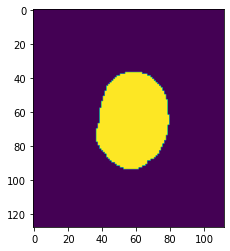

In [14]:
plt.imshow(mask)

In [15]:
autorift_results = list(out_dir.glob('*Offset.tif'))
for ras in autorift_results:
    data, profile = read_raster(ras)
    
    tmp = data.copy()
    tmp[mask == 1] = np.nan
    median = np.nanmedian(tmp)
    # print(median)
    data = data - median
    write_raster(data,profile,corrected_dir / ras.name,nodata=0.0,dtype=rio.float32)

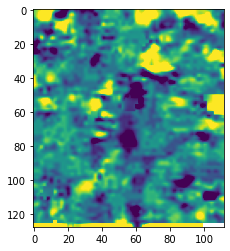

In [16]:
plt.imshow(data,vmin=-10,vmax=10)

## Create MintPy metadata file

In [17]:
files = [x.name for x in corrected_dir.glob('*Offset.tif')]
files.sort()

lines = [f'{f} {f[9:17]} {f[25:33]}\n' for f in files]
with open(corrected_dir / 'metadata.txt', 'w') as f:
    f.writelines(lines)

## Plotting Utilities

In [ ]:
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
# ax1.imshow(ref,cmap='gray')
# ax2.imshow(sec,cmap='gray')

In [ ]:
# f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
# dx = ax1.imshow(result.Dx,vmin=-3,vmax=3)
# ax1.set_title('Dx')
# dy = ax2.imshow(result.Dy,vmin=-3,vmax=3)
# ax2.set_title('Dy')
# sr = ax3.imshow(result.ChipSizeX)
# ax3.set_title('Chip Size')
# plt.tight_layout()